#**Análisis de serie de tiempo y modelado usando métodos clásicos**

### **Preparar el notebook**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns

### **Cargar los datos preparados**

In [4]:
dfsuro = pd.read_csv('/content/drive/MyDrive/ProyectoIntegrador2/datos_suroeste.csv')

In [5]:
print(dfsuro.shape)
dfsuro.head()

(4117, 16)


,Unnamed: 0,ID,ELEMENTO,NODO,FECHA,COORD_LONG,COORD_LAT,REGION,SUBREGION,GRUPO_RESPONSABLE,CRITICIDAD_NUM,MUNICIPIO,CIRCUITO,PENDIENTE,ESTADO,tipo
0,3,14962964.0,FR46394,NaN,2023-02-10 20:34:35,-76.031442,6.135418,SUROESTE,AMAGA,DE25,64.0,5847.0,507-12,TRABAJOS DE PODA,CERRADA,OT
1,10,4946322.0,F54128,NaN,2021-02-27 16:17:36,-75.949641,6.176642,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT
2,11,11918713.0,FR5175,NaN,2022-08-05 07:22:47,-75.945599,6.222647,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT
3,153,13222653.0,FR5144,553018.0,2022-10-14 16:36:05,-75.990291,6.171016,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT
4,156,4916076.0,F54165,NaN,2021-02-20 14:04:59,-75.918451,5.997762,SUROESTE,AMAGA,DE25,64.0,5209.0,518-13,TRABAJOS DE PODA,CANCELADA,OT


In [6]:
dfsuro.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [7]:
# Dar formato al campo FECHA
dfsuro['FECHA'] = pd.to_datetime(dfsuro['FECHA'], format='%Y-%m-%d %H:%M:%S.%f')
# Dar formato al campo ID
dfsuro['ID'] = dfsuro['ID'].astype(int)

In [8]:
dfsuro.dtypes

ID                            int64
ELEMENTO                     object
NODO                        float64
FECHA                datetime64[ns]
COORD_LONG                  float64
COORD_LAT                   float64
REGION                       object
SUBREGION                    object
GRUPO_RESPONSABLE            object
CRITICIDAD_NUM              float64
MUNICIPIO                   float64
CIRCUITO                     object
PENDIENTE                    object
ESTADO                       object
tipo                         object
dtype: object

### **Análisis de la serie de tiempo con frecuencia semanal**

In [9]:
dfsuro['fecha_semana'] = pd.to_datetime(dfsuro['FECHA']).dt.to_period('W')

In [10]:
dfsuro.head()

,ID,ELEMENTO,NODO,FECHA,COORD_LONG,COORD_LAT,REGION,SUBREGION,GRUPO_RESPONSABLE,CRITICIDAD_NUM,MUNICIPIO,CIRCUITO,PENDIENTE,ESTADO,tipo,fecha_semana
0,14962964,FR46394,NaN,2023-02-10 20:34:35,-76.031442,6.135418,SUROESTE,AMAGA,DE25,64.0,5847.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2023-02-06/2023-02-12
1,4946322,F54128,NaN,2021-02-27 16:17:36,-75.949641,6.176642,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2021-02-22/2021-02-28
2,11918713,FR5175,NaN,2022-08-05 07:22:47,-75.945599,6.222647,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2022-08-01/2022-08-07
3,13222653,FR5144,553018.0,2022-10-14 16:36:05,-75.990291,6.171016,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2022-10-10/2022-10-16
4,4916076,F54165,NaN,2021-02-20 14:04:59,-75.918451,5.997762,SUROESTE,AMAGA,DE25,64.0,5209.0,518-13,TRABAJOS DE PODA,CANCELADA,OT,2021-02-15/2021-02-21


Se extrae la serie semanal, haciendo el conteo de eventos de Trabajos de Poda generados por semana

In [11]:
serie_suro = pd.DataFrame(dfsuro.groupby(['fecha_semana'])['ID'].count())

Se obtiene una serie con 182 observaciones

In [12]:
print(serie_suro.shape)

(182, 1)


Se renombra la columna para mayor claridad

In [13]:
serie_suro.rename(columns={'ID':'CANT_EVENTOS'},inplace=True)

In [14]:
serie_suro.head()

,CANT_EVENTOS
fecha_semana,
2019-10-28/2019-11-03,1
2019-11-04/2019-11-10,4
2019-11-11/2019-11-17,6
2019-11-18/2019-11-24,12
2019-11-25/2019-12-01,9


In [15]:
serie_suro.dtypes

CANT_EVENTOS    int64
dtype: object

<Axes: xlabel='fecha_semana'>

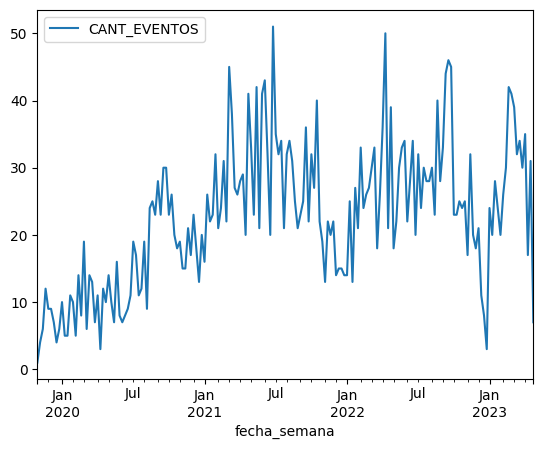

In [16]:
serie_suro.plot()

Se observa en la gráfica una tendencia creciente en la cantidad de eventos registrados. Esto se debe a un subregistro de los eventos en la etapa inicial de estabilización del sistema donde se almacenan los datos. Con el fin de evitar sesgos en las estimaciones se eliminarán los registros correspondientes a este periodo de estabilización.

In [17]:
#Seleccionamos los datos de la serie que se usarán.
serie_suro=serie_suro.iloc[44:-1]
serie_suro

,CANT_EVENTOS
fecha_semana,
2020-08-31/2020-09-06,28
2020-09-07/2020-09-13,23
2020-09-14/2020-09-20,30
2020-09-21/2020-09-27,30
2020-09-28/2020-10-04,23
...,...
2023-03-13/2023-03-19,34
2023-03-20/2023-03-26,30
2023-03-27/2023-04-02,35


<Axes: xlabel='fecha_semana'>

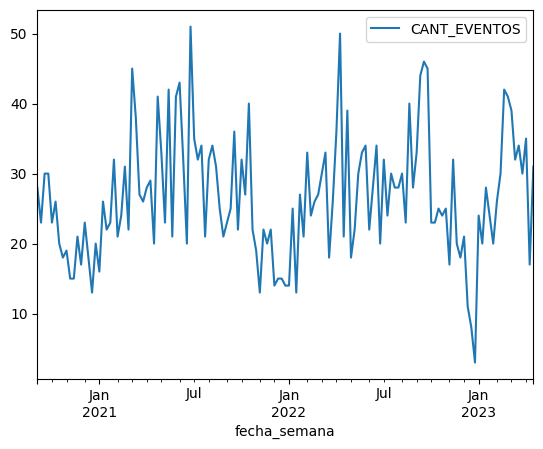

In [18]:
serie_suro.plot()

In [ ]:
ser2 = serie_suro.reset_index()
ser2['year'] = [d.year for d in ser2.fecha_semana]
ser2['month'] = [d.month for d in ser2.fecha_semana]

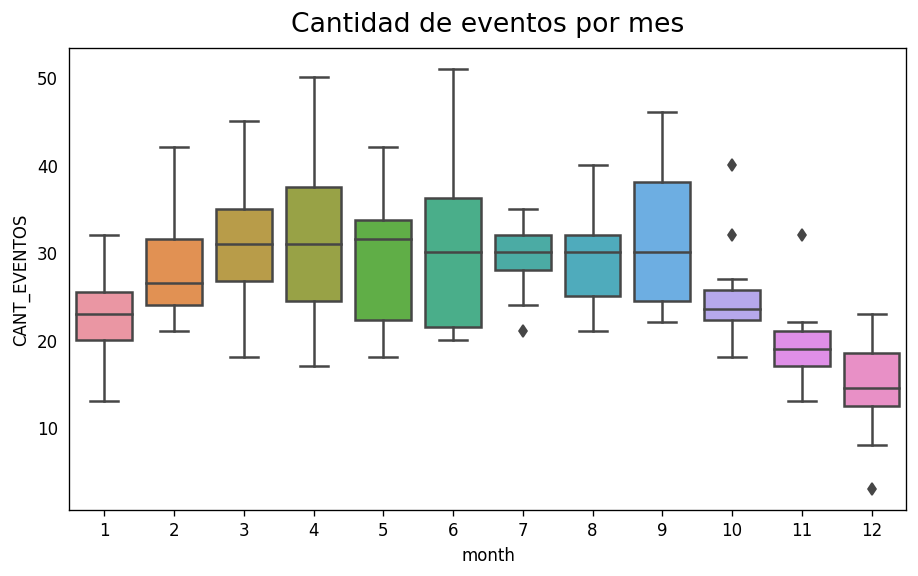

In [82]:
# Box Plot para observar la estacionalidad de los datos
sns.boxplot(x='month', y='CANT_EVENTOS', data=ser2)
plt.title('Cantidad de eventos por mes', fontsize=16)
plt.show()

In [21]:
# plt.figure(figsize = (10,6))
# plt.suptitle('Estacionalidad - 2021 -2023')
# ax1 = plt.subplot(4,1,1)
# plt.plot('week', 'CANT_EVENTOS', data = ser2.loc[ser2.year == 2020])
# plt.xlim(1,52)
# plt.tick_params('x', labelbottom=False)
# ax1 = plt.subplot(4,1,2)
# plt.plot('week', 'CANT_EVENTOS', data = ser2.loc[ser2.year == 2021])
# plt.xlim(1,52)
# plt.tick_params('x', labelbottom=False)
# ax2 = plt.subplot(4,1,3)
# plt.plot('week', 'CANT_EVENTOS', data = ser2.loc[ser2.year == 2022])
# plt.xlim(1,52)
# plt.tick_params('x', labelbottom=False)
# plt.subplot(4,1,4)
# ax3 = plt.plot('week', 'CANT_EVENTOS', data = ser2.loc[ser2.year == 2023])
# plt.xlim(1,52)
# #plt.tick_params('x', labelbottom=False)
# plt.show()

####**Test de Estacionaridad**

Se verificará la estacionaridad de la serie a través de las pruebas: 
* Augmented Dickey-Fuller test (ADF)
* Kwiatkowski-Phillips-Schmidt-Shin (KPSS) 




In [22]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(serie_suro.CANT_EVENTOS.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(serie_suro.CANT_EVENTOS.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')

ADF Statistic: -4.6938729291148755
p-value: 8.641153793993241e-05
Critial Values:
   1%, -3.479742586699182
Critial Values:
   5%, -2.88319822181578
Critial Values:
   10%, -2.578319684499314

KPSS Statistic: 0.102893
p-value: 0.100000
Critial Values:
Critial Values:
Critial Values:
Critial Values:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Para el caso del ADF test, la hipótesis nula es que la serie de tiempo es no estacionaria. Así, dado que el p-value en el test es 0.0000864 (menor que el nivel de significancia 0.05), entonces se rechaza la hipótesis nula.

Para el caso del KPSS test la hipótesis nula es la opuesta al ADF test, es decir que la serie es estacionaria. Así, dado que el p-value en el test es 0.100000 (mayor que el nivel de significancia 0.05), entonces no se rechaza la hipótesis nula.

Luego, de acuerdo con los resultados conjuntos de las pruebas, la **serie es estacionaria**.

#### **Descomposición**

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

volver el índice una sola fecha del rango, tomando solo la inicial

In [24]:
serie_suro.index = serie_suro.index.to_timestamp()

In [25]:
# exportar la serie de tiempo
serie_suro.to_csv('/content/drive/MyDrive/ProyectoIntegrador2/datos_serietiempo.csv')

In [26]:
freq = 'W'

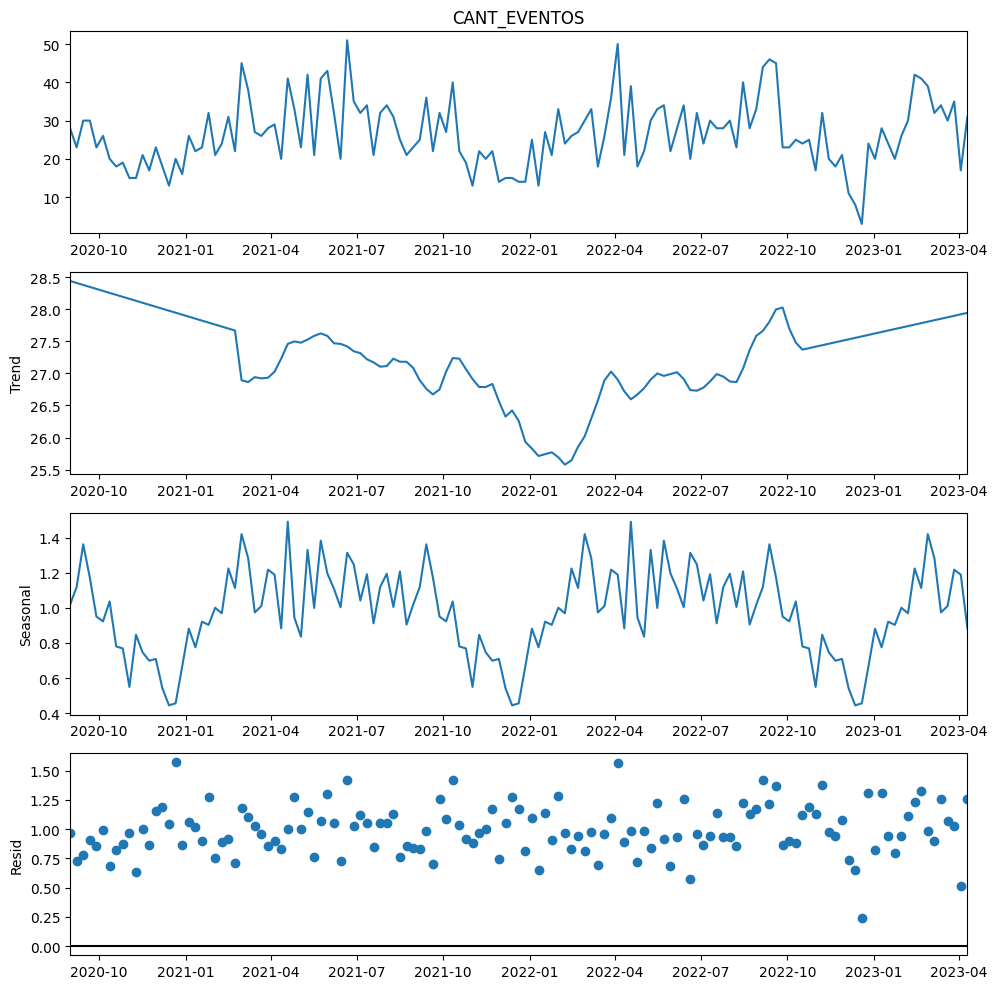

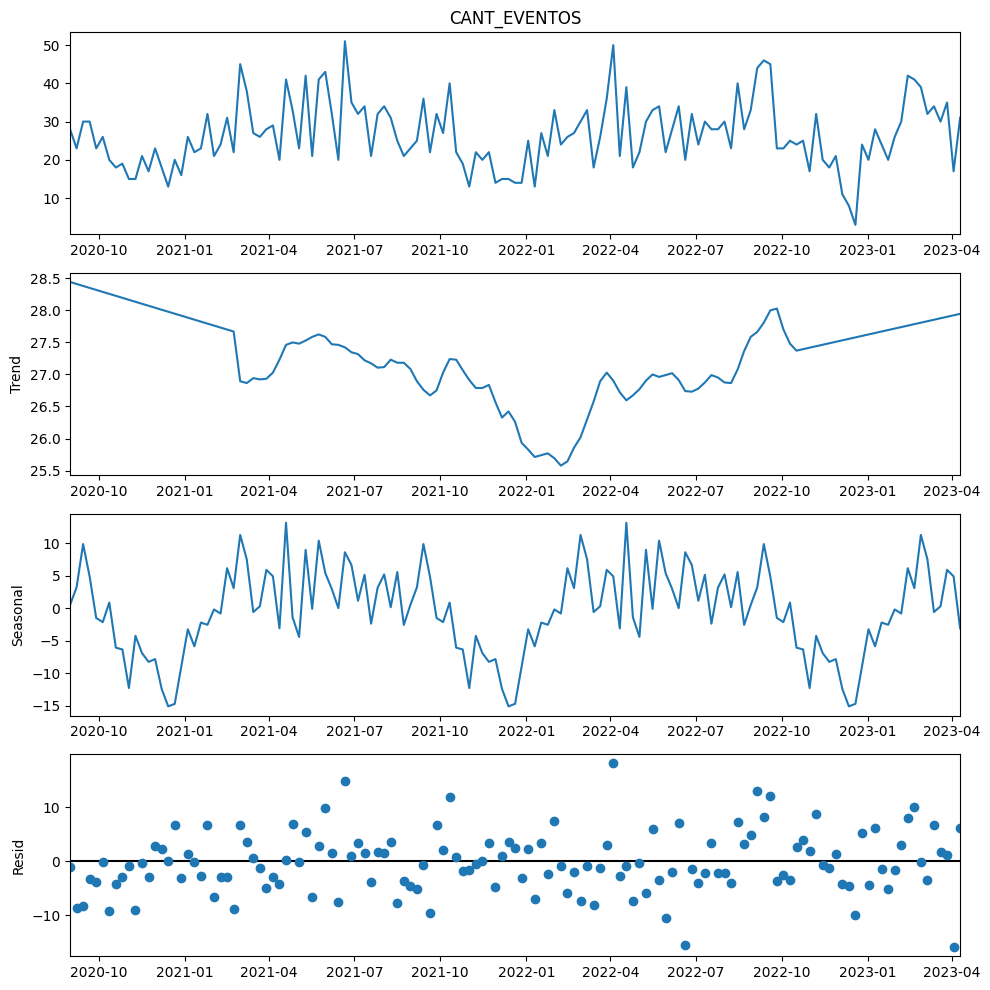

In [27]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(serie_suro['CANT_EVENTOS'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(serie_suro['CANT_EVENTOS'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot()#.suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot()#.suptitle('Additive Decompose', fontsize=22)
plt.show()

#### **Remover el componente de estacionalidad de la serie**

**Eliminar estacionalidad usando la descomposición multiplicativa**

[]

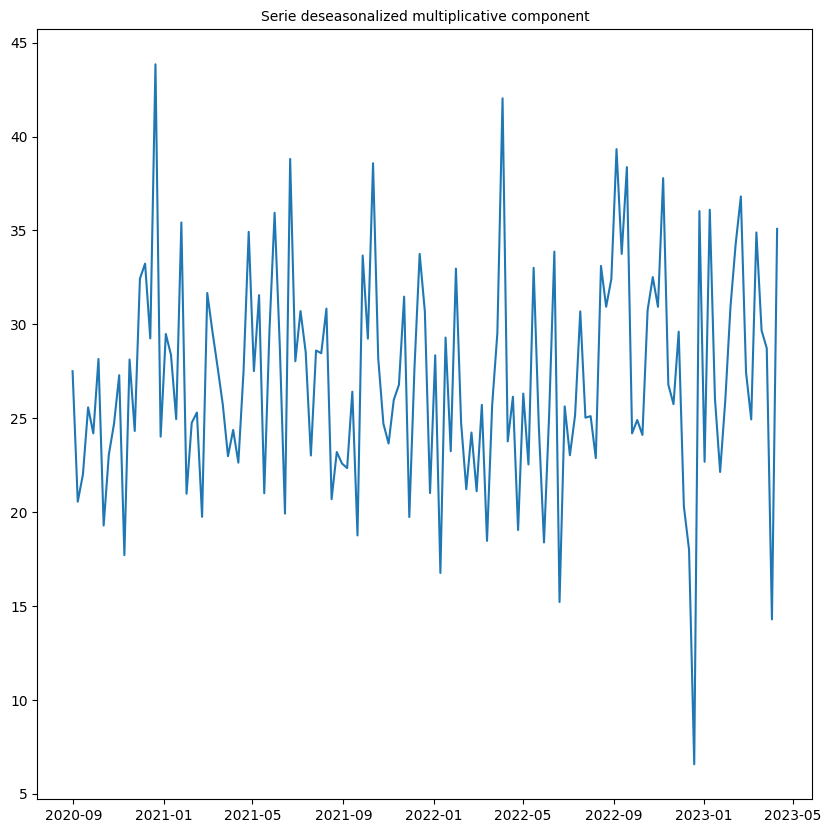

In [28]:
# Subtracting the seasonal Component.

# Time Series Decomposition
result_mul = seasonal_decompose(serie_suro['CANT_EVENTOS'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized_mul = serie_suro.CANT_EVENTOS.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized_mul)
plt.title('Serie deseasonalized multiplicative component', fontsize=10)
plt.plot()

**Eliminar estacionalidad usando la descomposición aditiva**

[]

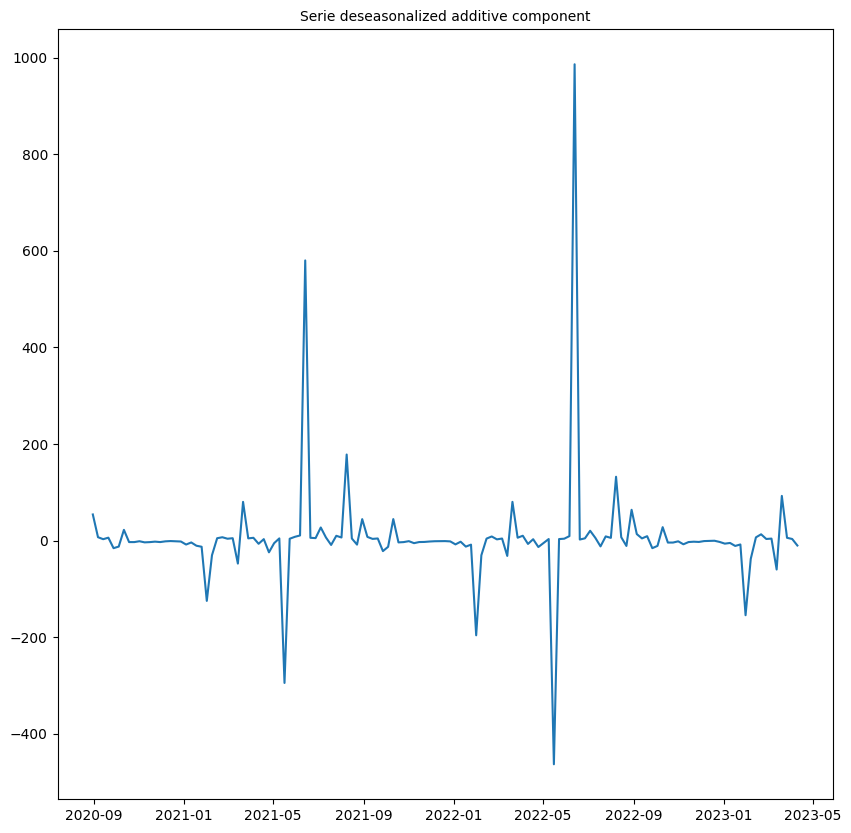

In [29]:
# Subtracting the seasonal Component.

# Time Series Decomposition
result_add = seasonal_decompose(serie_suro['CANT_EVENTOS'], model='additive', extrapolate_trend='freq')

# Deseasonalize
deseasonalized_add = serie_suro.CANT_EVENTOS.values / result_add.seasonal

# Plot
plt.plot(deseasonalized_add)
plt.title('Serie deseasonalized additive component', fontsize=10)
plt.plot()

Observando las gráficas anteriores y comparando el resultado de ambos métodos, se identifica que la descomposición multiplicativa logra remover de mejor manera el componente estacional de la serie, y por lo tanto se selecciona esta descomposición para continuar con el análisis de la serie de tiempo.


#### **Extracción de la componente de tendencia de la serie**

Text(0.5, 1.0, 'Serie Suro detrended by subtracting the trend component')

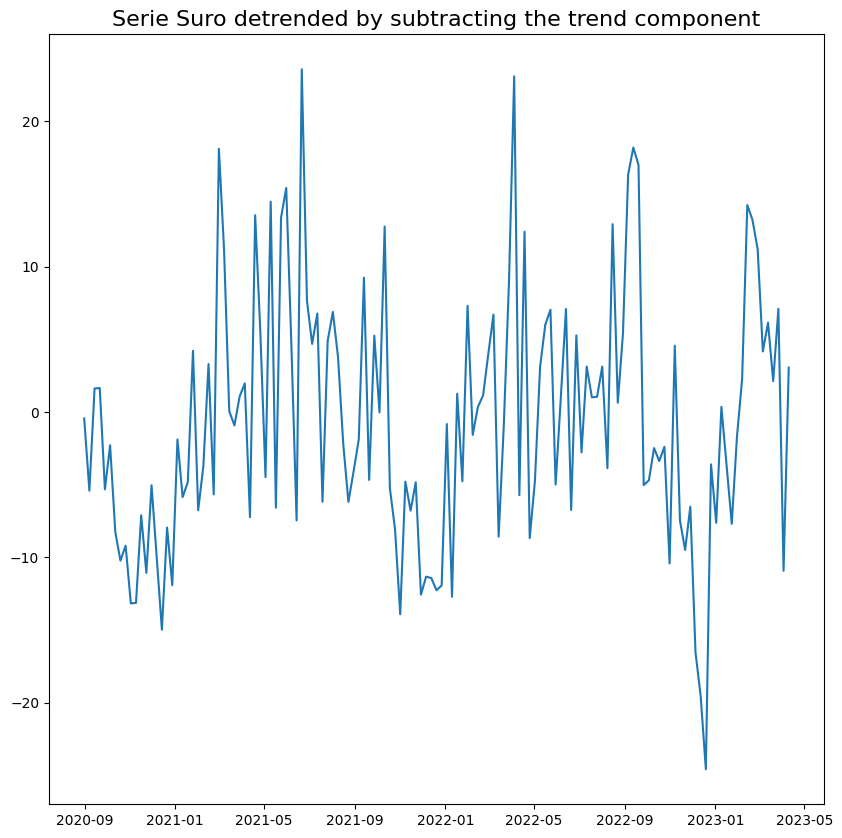

In [30]:
# Using statmodels: Subtracting the Trend Component.

from statsmodels.tsa.seasonal import seasonal_decompose

result_mul1 = seasonal_decompose(serie_suro['CANT_EVENTOS'], model='multiplicative', extrapolate_trend='freq')

detrended_mul1 = serie_suro.CANT_EVENTOS.values - result_mul1.trend

plt.plot(detrended_mul1)
plt.title('Serie Suro detrended by subtracting the trend component', fontsize=16)

Text(0.5, 1.0, 'Serie Suro detrended by subtracting the trend component')

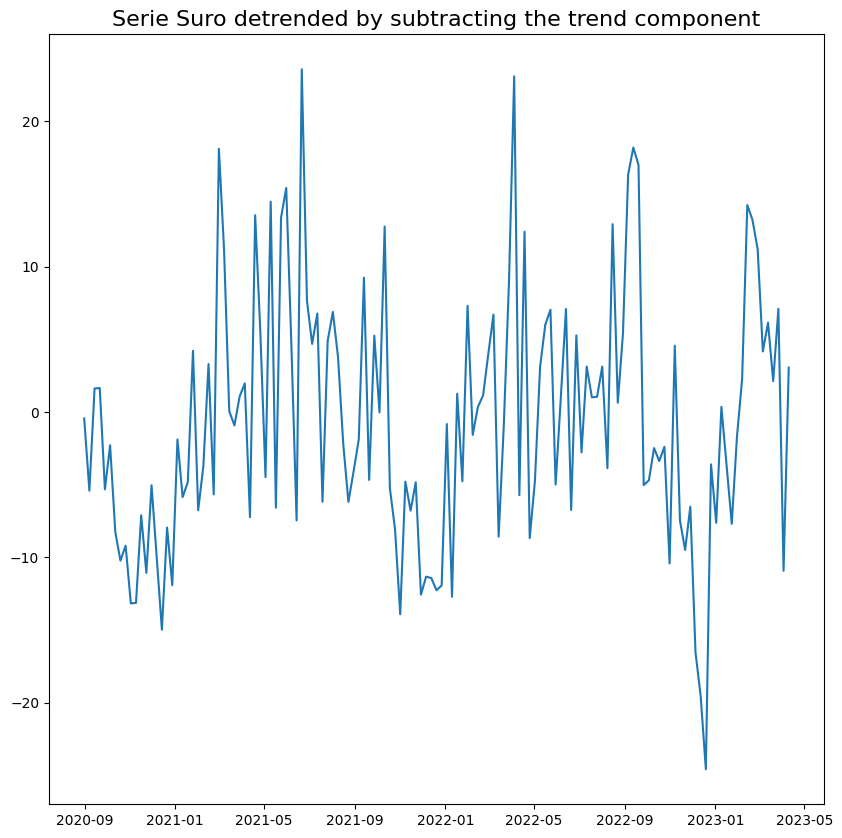

In [31]:
# Using statmodels: Subtracting the Trend Component.

from statsmodels.tsa.seasonal import seasonal_decompose

result_add1 = seasonal_decompose(serie_suro['CANT_EVENTOS'], model='additive', extrapolate_trend='freq')

detrended_add1 = serie_suro.CANT_EVENTOS.values - result_add1.trend

plt.plot(detrended_add1)
plt.title('Serie Suro detrended by subtracting the trend component', fontsize=16)

Prueba de estacionalidad de la serie

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

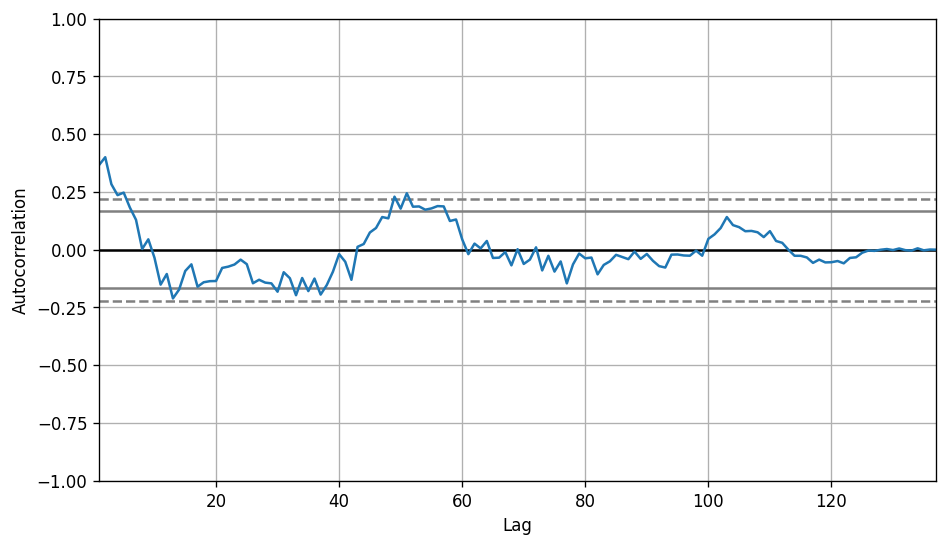

In [32]:
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(serie_suro.CANT_EVENTOS.tolist())

#### **Funciones de autocorrelación y autocorrelación parcial**

Se calculará para la serie de datos original y para la serie de datos sin el componente estacional usando descomposición multiplicativa, como se indicó previamente.

*Serie de datos original*

In [33]:
serie_suro.CANT_EVENTOS

fecha_semana
2020-08-31    28
2020-09-07    23
2020-09-14    30
2020-09-21    30
2020-09-28    23
              ..
2023-03-13    34
2023-03-20    30
2023-03-27    35
2023-04-03    17
2023-04-10    31
Freq: W-MON, Name: CANT_EVENTOS, Length: 137, dtype: int64

*Serie de datos sin el componente estacional, usando descomposición multiplicativa*

In [34]:
deseasonalized_mul

fecha_semana
2020-08-31    27.505400
2020-09-07    20.559110
2020-09-14    22.010739
2020-09-21    25.582978
2020-09-28    24.197210
                ...    
2023-03-13    34.893253
2023-03-20    29.677332
2023-03-27    28.728219
2023-04-03    14.291906
2023-04-10    35.086142
Freq: W-MON, Name: seasonal, Length: 137, dtype: float64

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


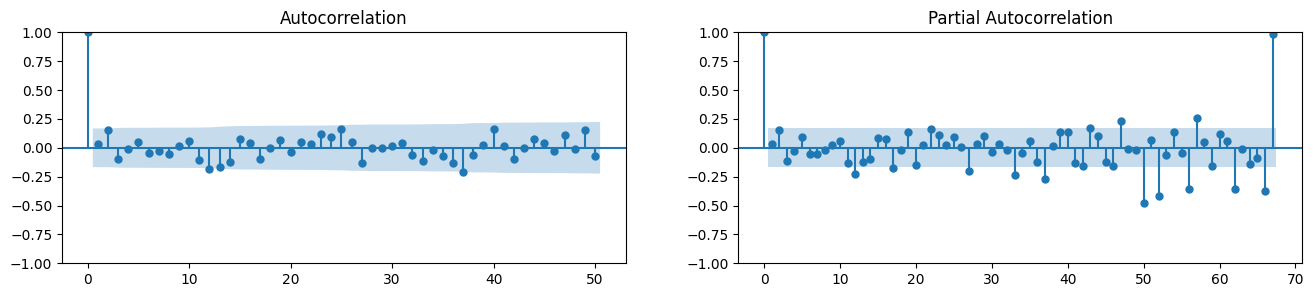

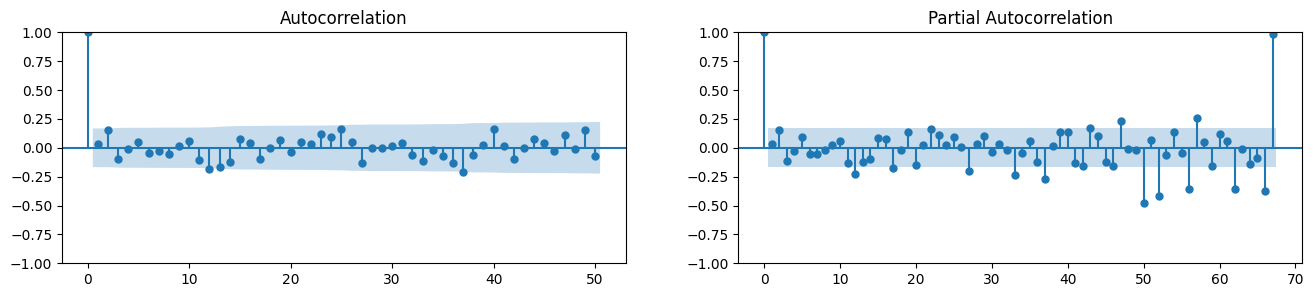

In [35]:
#cálculo de las funciones de autocorrelación y autocorrelación parcial
#con los datos de la serie desestacionalizada (componente multiplicativo)

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
acf_50 = acf(deseasonalized_mul, nlags=50)
pacf_50 = pacf(deseasonalized_mul, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(deseasonalized_mul.tolist(), lags=50, ax=axes[0])
plot_pacf(deseasonalized_mul.tolist(), lags=67, ax=axes[1])

Se observa en las gráficas anteriores que se pierde la relación de la serie de datos con sus rezagos.

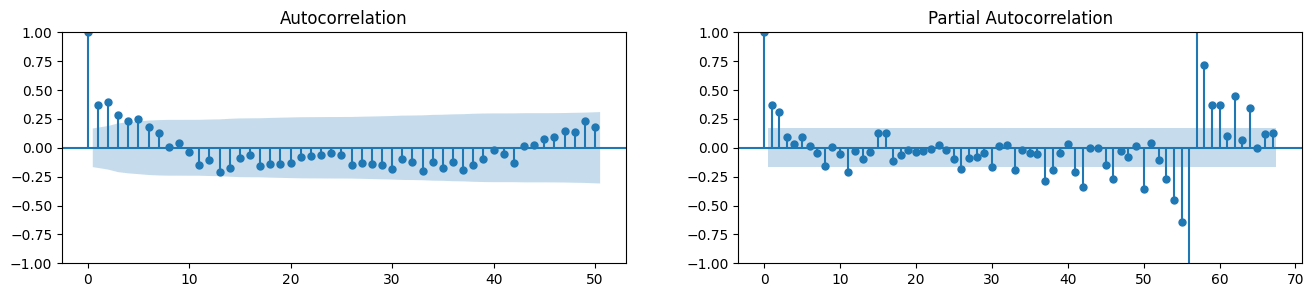

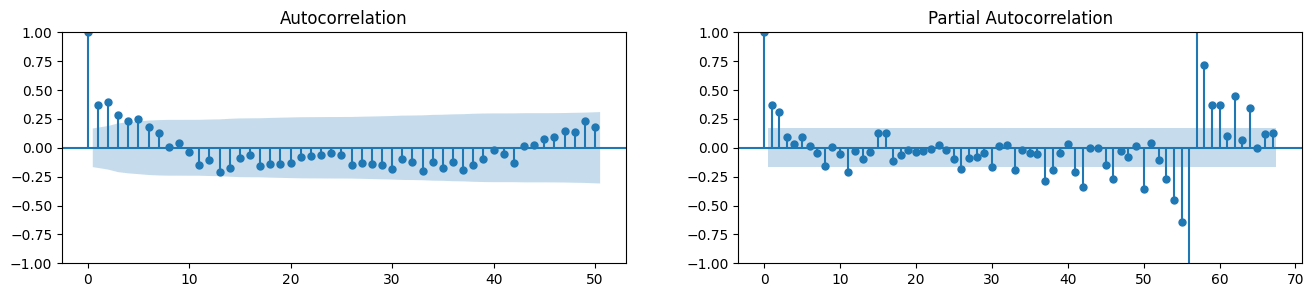

In [36]:
#cálculo de las funciones de autocorrelación y autocorrelación parcial
#con datos de la serie de tiempo original

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
acf_50 = acf(serie_suro.CANT_EVENTOS, nlags=50)
pacf_50 = pacf(serie_suro.CANT_EVENTOS, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(serie_suro.CANT_EVENTOS.tolist(), lags=50, ax=axes[0])
plot_pacf(serie_suro.CANT_EVENTOS.tolist(), lags=67, ax=axes[1])

Se observa una autocorrelación de la serie con tres rezagos y una autocorrelación parcial con dos rezagos. 

Con estos datos se podrá determinar el orden de los procesos en un modelo ARIMA
(AR = 2 y MA = 3)

Para la serie de tiempo original las funciones de autocorrelación y autocorrelación parcial indican que los **valores previos de la serie (rezagos) pueden ayudar a predecir el valor actual**.

De acuerdo con los resultados anteriores, **el análisis y modelado de la serie de tiempo se realizará con datos en su formato original**, sin realizar sobre estos ninguna transformación, con el fin de mantener la capacidad predictiva de la serie con base en sus valores previos.

In [37]:
#Exportar los datos de la autocorrelación y la autocorrelación parcial

np.savetxt("/content/drive/MyDrive/ProyectoIntegrador2/datos_export/autocorr.csv", acf_50, delimiter=",")
np.savetxt("/content/drive/MyDrive/ProyectoIntegrador2/datos_export/part_autocorr.csv", pacf_50, delimiter=",")

#### Lag plots

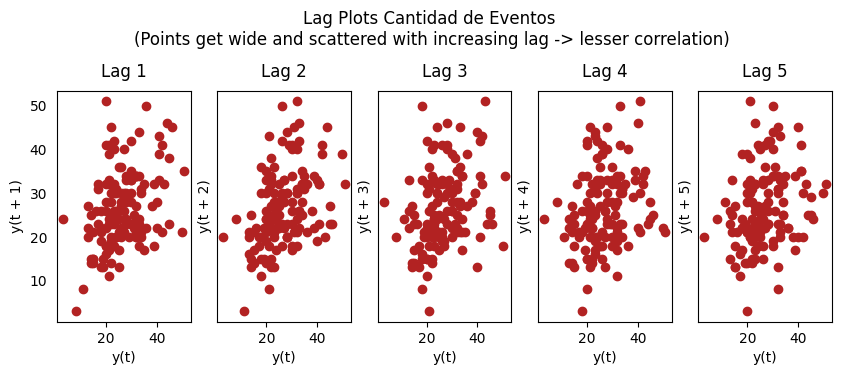

In [38]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})


# Plot
fig, axes = plt.subplots(1, 5, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    lag_plot(serie_suro.CANT_EVENTOS, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots Cantidad de Eventos \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    
  
plt.show()

### **Modelado de la serie de tiempo**

**Dividir el conjunto de datos en set de entrenamiento y set de prueba**

In [39]:
#se define el número de periodos que serán usados como conjunto de datos de entrenamiento
Ntest = 12

train = serie_suro.iloc[:-Ntest]
test = serie_suro.iloc[-Ntest:]

In [40]:
train.shape

(125, 1)

In [41]:
test.shape

(12, 1)

In [42]:
train_idx = serie_suro.index <= train.index[-1]
test_idx = serie_suro.index > train.index[-1]

In [43]:
train_idx

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,

#### **Modelo ARIMA**

Como se indicó anteriormente se utilizarán los resultados de las funciones de autocorrelación y autocorrelación parcial para determinar el orden de los procesos del modelo ARIMA, así AR = 2 y MA = 3

In [44]:
#Se define el modelo y se ajusta el modelo sobre el conjunto de datos de entrenamiento
model_ARIMA = ARIMA(train, order =(2,0,3))
model_ARIMA_fit = model_ARIMA.fit()

In [45]:
#Se hace la predicción de los valores para el conjunto de datos de entrenamiento y se almacena en el dataframe original
serie_suro.loc[train_idx, 'ARMA'] = model_ARIMA_fit.predict(start = train.index[0], end= train.index[-1])

In [46]:
#Se obtiene la predicción para el conjunto de datos de prueba
prediction_result_ARIMA = model_ARIMA_fit.get_forecast(Ntest)
forecast_ARIMA = prediction_result_ARIMA.predicted_mean

In [47]:
#Se almacena el resultado de la predicción en el dataframe original
serie_suro.loc[test_idx, 'ARMA']= forecast_ARIMA

In [48]:
#Se define una función para el ajuste del modelo y para graficar los resultados
def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize = (10,4))
    ax.plot(serie_suro['CANT_EVENTOS'], label = 'data')
    
    #plot the curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train.index, train_pred, color = 'green', label = 'fitted')
    
    #forecast the test set
    
    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int['lower CANT_EVENTOS'], conf_int['upper CANT_EVENTOS']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label = 'Forecast')
    ax.fill_between(test.index, lower, upper, color = 'red', alpha = 0.3)
    
    ax.legend()

**Gráfica del resultado del modelo ARIMA**

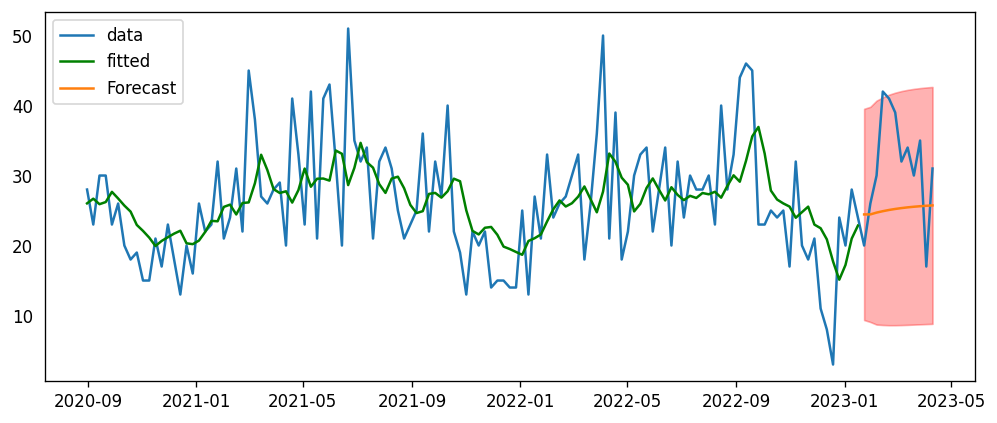

In [49]:
plot_fit_and_forecast(model_ARIMA_fit)

**Calcular el error de la predicción**

In [50]:
#RMSE
t = serie_suro.loc[test_idx, 'CANT_EVENTOS']
y = serie_suro.loc[test_idx, 'ARMA']
RMSE_ARIMA = np.sqrt(np.mean((t-y)**2))

print("Error de la predicción")
print("ARIMA Model RMSE: ", RMSE_ARIMA)

Error de la predicción
ARIMA Model RMSE:  9.63457811420799


In [51]:
mean_absolute_error(y, t)

8.422325927557564

**Exportar los datos**

Exportar los resultados de la predicción del modelo y el intervalo de confianza

In [52]:
conf_int = prediction_result_ARIMA.conf_int()
lower, upper = conf_int['lower CANT_EVENTOS'], conf_int['upper CANT_EVENTOS']

In [53]:
#crear un dataframe para almacenar los resultados 
df_ARMA = serie_suro[['CANT_EVENTOS', 'ARMA']]
df_ARMA = df_ARMA.merge(conf_int, how = 'left', left_index = True, right_index = True)

In [54]:
#Exportar los datos en un archivo plano
df_ARMA.to_csv('/content/drive/MyDrive/ProyectoIntegrador2/datos_export/ARMA.csv')

#### **Modelo Autoarima**

In [55]:
#Se define el modelo y se ajusta el modelo sobre el conjunto de datos de entrenamiento 
model_autoarima = pm.auto_arima(train, trace = True, suppress_warnings = True, seasonal = True, m=52)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=879.477, Time=23.22 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=899.729, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=884.722, Time=5.58 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=889.099, Time=1.51 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1185.439, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=878.290, Time=5.14 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=877.403, Time=0.29 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=878.250, Time=10.05 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=875.626, Time=0.24 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=876.432, Time=5.83 sec
 ARIMA(1,0,2)(0,0,1)[52] intercept   : AIC=876.600, Time=6.57 sec
 ARIMA(1,0,2)(1,0,1)[52] intercept   : AIC=877.865, Time=11.72 sec
 ARIMA(0,0,2)(0,0,0)[52] intercept   : AIC=882.527, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=874.838, Time=0.39 sec
 ARIMA(1,0,1)(1,0,0)[52] inte

In [83]:
print(model_autoarima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -433.419
Date:                Tue, 06 Jun 2023   AIC                            874.838
Time:                        18:30:41   BIC                            886.151
Sample:                    08-31-2020   HQIC                           879.434
                         - 01-16-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4544      2.536      1.362      0.173      -1.517       8.426
ar.L1          0.8670      0.094      9.187      0.000       0.682       1.052
ma.L1         -0.6175      0.138     -4.463      0.0

Se obtiene que el mejor modelo es un ARIMA(1,0,1)

In [57]:
#Se obtiene la predicción y el intervalo de confianza para el conjunto de datos de prueba
test_pred, confint = model_autoarima.predict(n_periods = Ntest, return_conf_int = True)

In [58]:
#Se hace la predicción de los valores para el conjunto de datos de entrenamiento
train_pred = model_autoarima.predict_in_sample(start=0, end=-1)

**Gráfica del resultado del modelo AUTOARIMA**

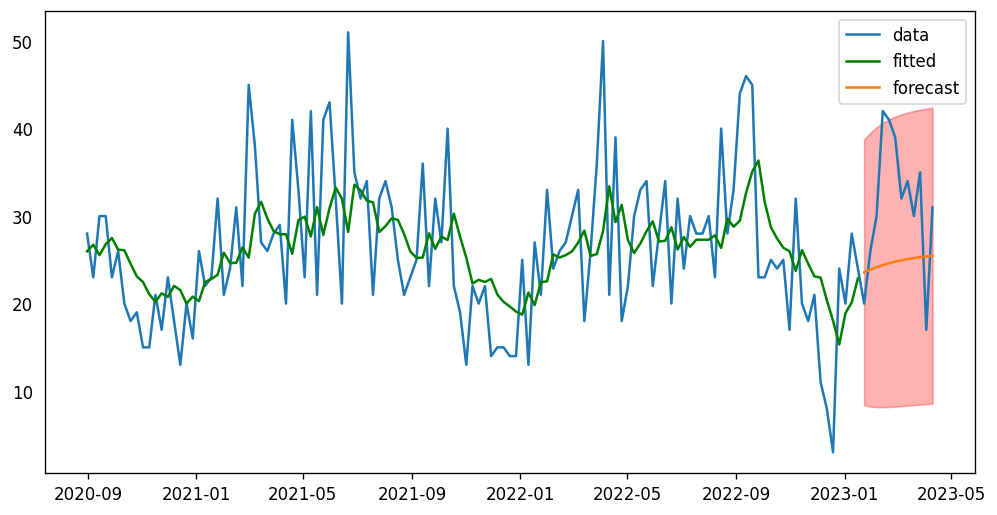

In [59]:
fig, ax =plt.subplots(figsize= (10,5))
ax.plot(serie_suro.index, serie_suro['CANT_EVENTOS'], label='data')
ax.plot(train.index, train_pred, label='fitted', color = 'green')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.3)

ax.legend();

**Calcular el error de la predicción**

In [60]:
#RMSE
t = serie_suro.loc[test_idx, 'CANT_EVENTOS']
y = test_pred
RMSE_autoARIMA = np.sqrt(np.mean((t-y)**2))

print("Error de la predicción")
print("autoARIMA Model RMSE: ", RMSE_autoARIMA)

Error de la predicción
autoARIMA Model RMSE:  9.908948506478664


In [61]:
mean_absolute_error(y, t)

8.67277694904467

**Exportar los datos**

Exportar los resultados de la predicción del modelo y el intervalo de confianza

In [62]:
#crear un dataframe para almacenar los datos del intervalo de confianza para la predicción 
df_confint = pd.DataFrame(confint, columns = ['confint_inf','confint_sup'])

In [63]:
test_pred = pd.Series(test_pred, name='test_pred')

In [64]:
#crear un dataframe para almacenar los resultados de la predicción 
df_AutoARIMA = serie_suro[['CANT_EVENTOS']]
df_AutoARIMA = df_AutoARIMA.merge(train_pred, how = 'left', left_index = True, right_index = True)
df_AutoARIMA = df_AutoARIMA.merge(test_pred, how = 'left', left_index = True, right_index = True)

In [65]:
#Exportar los datos en archivos planos
df_AutoARIMA.to_csv('/content/drive/MyDrive/ProyectoIntegrador2/datos_export/autoARIMA.csv')
df_confint.to_csv('/content/drive/MyDrive/ProyectoIntegrador2/datos_export/confint_autoARIMA.csv')

**Condición de indisponibilidad del sistema de información**

Como parte del entendimiento del negocio, se han identificado situaciones son de se presenta una indisponibilidad del sistema de información donde se crean los eventos y se almacenan los datos, lo cual genera un comportamiento atípico en la serie de tiempo. Con el fin de evitar sezgos en las estimaciones, se crea una variable *dummy* que refleje la condición de indisponibilidad del sistema (fechas donde han ocurrido este tipo de situaciones).

In [66]:
#Se crea sobre el dataframe original una variable dummy con valor 1 
#para las fechas donde se tiene conocimiento de situaciones de indisponibilidad del sistema de información

serie_suro['DUMMY'] = np.where(serie_suro.index.isin(['2022-12-19 00:00:00', '2022-12-12 00:00:00', '2022-12-05 00:00:00']), 1, 0)

In [67]:
serie_suro.tail(20)

,CANT_EVENTOS,ARMA,DUMMY
fecha_semana,,,
2022-11-28,21,22.990092,0
2022-12-05,11,22.473309,1
2022-12-12,8,20.884341,1
2022-12-19,3,17.728689,1
2022-12-26,24,15.117991,0
2023-01-02,20,17.222668,0
2023-01-09,28,20.988256,0
2023-01-16,24,22.845599,0
2023-01-23,20,24.443788,0


In [68]:
#Se divide nuevamente el conjunto de datos en los subconjuntos de entrenamiento (train) y prueba (test)
#se define el número de periodos que serán usados como conjunto de datos de entrenamiento
Ntest = 12

train_exog = serie_suro.iloc[:-Ntest]
test_exog = serie_suro.iloc[-Ntest:]

#### **Modelo ARIMAX**


Modelo de serie de tiempo incluyendo la variable exógena *DUMMY*

Para el modelo se utiliza el orden de los procesos entregado por el modelo **AUTOARIMA**

In [69]:
#Se define el modelo y se ajusta sobre el conjunto de datos de entrenamiento
model_ARIMAX = SARIMAX(train_exog.CANT_EVENTOS, exog=train_exog.DUMMY, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))
model_ARIMAX_fit = model_ARIMAX.fit(disp=False)

In [70]:
#Se hace la predicción de los valores para el conjunto de datos de entrenamiento y se almacena en el dataframe original
serie_suro.loc[train_idx, 'ARIMAX'] = model_ARIMAX_fit.predict(start = train_exog.index[0], end= train_exog.index[-1], exog=train_exog.DUMMY)

In [71]:
serie_suro.head()

,CANT_EVENTOS,ARMA,DUMMY,ARIMAX
fecha_semana,,,,
2020-08-31,28,26.023835,0,0.000000
2020-09-07,23,26.693598,0,26.145946
2020-09-14,30,25.906902,0,24.480383
2020-09-21,30,26.209970,0,26.453862
2020-09-28,23,27.668547,0,27.487875


In [72]:
#serie_suro[['CANT_EVENTOS', 'ARIMAX']].plot(figsize= (10,5));

In [73]:
#Se obtiene la predicción para el conjunto de datos de prueba
prediction_ARIMAX = model_ARIMAX_fit.get_prediction(steps = 12, exog=test_exog.DUMMY)

In [74]:
#Se almacena el resultado de la predicción en el dataframe original
serie_suro.loc[test_idx, 'ARIMAX'] = model_ARIMAX_fit.get_forecast(steps = 12, exog=test_exog.DUMMY).predicted_mean

In [75]:
#Se define una función para el ajuste del modelo y para graficar los resultados
def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize = (10,4))
    ax.plot(serie_suro['CANT_EVENTOS'], label = 'data')
    
    #plot the curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train.index, train_pred, color = 'green', label = 'fitted')
    
    #forecast the test set
    
    prediction_result = result.get_forecast(Ntest, exog=test_exog.DUMMY)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int['lower CANT_EVENTOS'], conf_int['upper CANT_EVENTOS']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label = 'Forecast')
    ax.fill_between(test.index, lower, upper, color = 'red', alpha = 0.3)
    
    ax.legend()

**Gráfica del resultado del modelo ARIMAX**

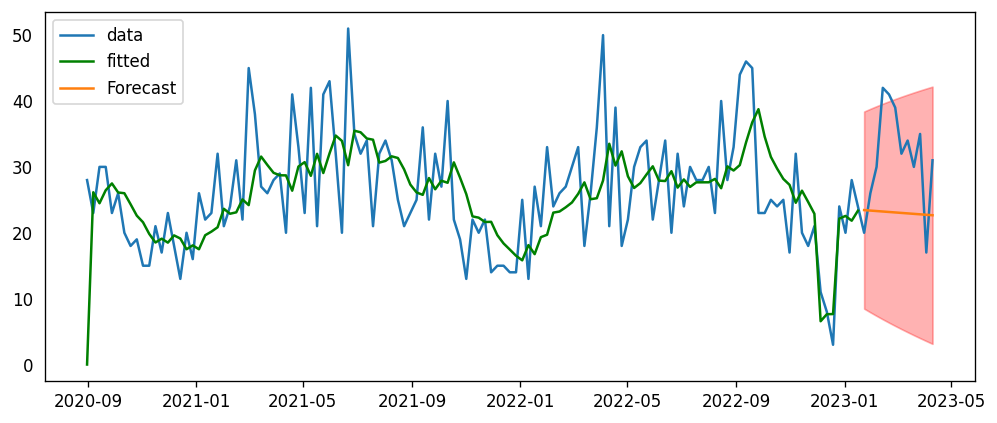

In [76]:
plot_fit_and_forecast(model_ARIMAX_fit)

**Calcular el error de la predicción**

In [85]:
#RMSE
t = serie_suro.loc[test_idx, 'CANT_EVENTOS']
y = serie_suro.loc[test_idx, 'ARIMAX']
RMSE_ARIMAX = np.sqrt(np.mean((t-y)**2))

print("Error de la predicción")
print("ARIMAX Model RMSE: ", RMSE_ARIMAX)
print("ARIMAX Model MAE: ", mean_absolute_error(y, t))

Error de la predicción
ARIMAX Model RMSE:  11.154120900116338
ARIMAX Model MAE:  9.896007346225964
